In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. Install Core Data Science Libraries (Pandas, NumPy, Scikit-learn)
!pip install pandas numpy scikit-learn

# 2. Install Hugging Face Transformers and PyTorch
# The '[sentencepiece]' is required for some tokenizers, and '[torch]' ensures PyTorch dependency.
!pip install transformers[sentencepiece] torch

# 3. Install NLTK (for Stopwords/Lemmatization)
!pip install nltk

# 4. Install spaCy (for Named Entity Recognition - NER)
!pip install spacy

# 5. Download the spaCy pre-trained model for English
# This model includes NER capabilities and is used for location extraction.
!python -m spacy download en_core_web_sm

# Download NLTK resources (needed for stopwords, etc., which you mentioned in cleaning)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 132.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
!pip install pandas numpy scikit-learn nltk

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

BASE_PATH = '/content/drive/MyDrive/'

FILE_PATHS = {
    'kaggle_train': BASE_PATH + 'kaggle_train.csv',
    'kaggle_test': BASE_PATH + 'kaggle_test.csv',

    'canada_wildfires': BASE_PATH + 'canada_wildfires_2016.csv',
    'ecuador_earthquake': BASE_PATH + 'ecuador_earthquake_2016.csv',
    'hurricane_harvey': BASE_PATH + 'hurricane_harvey_2017.csv',
    'hurricane_irma': BASE_PATH + 'hurricane_irma_2017.csv',
    'puebla_mexico_earthquake': BASE_PATH + 'puebla_mexico_earthquake_2017.csv',
    'srilanka_floods': BASE_PATH + 'srilanka_floods_2017.csv',

    # Eyewitness annotation datasets
    'eyewitness_earthquake': BASE_PATH + 'earthquakes_eyewitness_annotations_2000.csv',
    'eyewitness_floods': BASE_PATH + 'floods_eyewitness_annotations_2000.csv',
    'eyewitness_hurricanes': BASE_PATH + 'hurricanes_eyewitness_annotations_2004.csv',
}
DISASTER_TYPE_MAP = {
    'kaggle_train': 'UNKNOWN_KAGGLE',
    'kaggle_test': 'UNKNOWN_KAGGLE',
    'canada_wildfires': 'Wildfire',
    'ecuador_earthquake': 'Earthquake',
    'hurricane_harvey': 'Hurricane',
    'hurricane_irma': 'Hurricane',
    'puebla_mexico_earthquake': 'Earthquake',
    'srilanka_floods': 'Flood',
    'eyewitness_earthquake': 'Earthquake',
    'eyewitness_floods': 'Flood',
    'eyewitness_hurricanes': 'Hurricane',
}

In [8]:
all_labels = {}

for key, path in FILE_PATHS.items():
    try:
        df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
    except:
        df = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')

    # normalize column names
    cols = [c.strip().lower() for c in df.columns]

    # look for possible label columns
    possible_cols = [df.columns[i] for i, c in enumerate(cols)
                     if any(x in c for x in ['label', 'class', 'target', 'lable'])]

    if not possible_cols:
        print(f"No label column found in {key} -> columns = {df.columns.tolist()}")
        continue

    label_col = possible_cols[0]  # pick first match
    all_labels[key] = df[label_col].dropna().unique().tolist()

    print(f"{key}: using column '{label_col}'")

print("\n=== Unique labels per dataset ===")
for dataset, labels in all_labels.items():
    print(f"{dataset}: {labels}")

kaggle_train: using column 'target'
No label column found in kaggle_test -> columns = ['id', 'keyword', 'location', 'text']
canada_wildfires: using column 'class_label'
ecuador_earthquake: using column 'class_label'
hurricane_harvey: using column 'class_label'
hurricane_irma: using column 'class_label'
puebla_mexico_earthquake: using column 'class_label'
srilanka_floods: using column 'class_label'
eyewitness_earthquake: using column 'label'
eyewitness_floods: using column 'lable'
eyewitness_hurricanes: using column 'Lable'

=== Unique labels per dataset ===
kaggle_train: [1, 0]
canada_wildfires: ['rescue_volunteering_or_donation_effort', 'sympathy_and_support', 'infrastructure_and_utility_damage', 'other_relevant_information', 'displaced_people_and_evacuations', 'not_humanitarian', 'caution_and_advice', 'requests_or_urgent_needs']
ecuador_earthquake: ['sympathy_and_support', 'injured_or_dead_people', 'requests_or_urgent_needs', 'rescue_volunteering_or_donation_effort', 'infrastructure_

In [9]:
def binarize_label(label):
    if isinstance(label, str):
        label_lower = label.lower().strip()

        # 0: Non-Actionable or Non-Disaster (Including Sympathy and 'Don't Know')
        if label_lower in ['0', 'sympathy_and_support', 'not_humanitarian', 'not_relevant', 'non-eyewitness', 'non eyewitness', "don't know"]:
            return 0

        # 1: Disaster or Actionable Information (All other Crisis/Eyewitness labels)
        elif label_lower in [
            '1', 'injured_or_dead_people', 'requests_or_urgent_needs',
            'rescue_volunteering_or_donation_effort', 'infrastructure_and_utility_damage',
            'displaced_people_and_evacuations', 'caution_and_advice',
            'other_relevant_information', 'direct-eyewitness',
            'indirect-eyewitness', 'vulnerable direct-eyewitness', 'vulnerable-direct witness'
            ]:
            return 1
        else:
            return np.nan # Catch any unexpected labels

    elif pd.isna(label):
        return np.nan # Catch NaNs

    else:
        return int(label) # Handles Kaggle's pre-existing integer 0 or 1 labels

In [10]:
all_data_frames = []

for key, path in FILE_PATHS.items():
    try:
        # Load file with robust encoding
        df = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')

        # --- Standardize Columns ---
        col_map = {}
        for col in df.columns:
            col_lower = col.lower().strip()
            # Rename the messy columns to your standard column names
            if col_lower == 'target': col_map[col] = 'is_disaster'
            elif col_lower in ['class_label', 'label', 'lable']: col_map[col] = 'sub_category'
            elif col_lower == 'tweet_text': col_map[col] = 'text'
            elif col_lower == 'location': col_map[col] = 'location_raw'
            elif col_lower in ['tweet_id', 'id']: col_map[col] = 'id'

        df.rename(columns=col_map, inplace=True)

        # --- Add/Clean Required Columns ---

        # 1. Handle Unlabeled Kaggle Test Data (CRITICAL)
        if key == 'kaggle_test':
            df['is_disaster'] = np.nan
            df['sub_category'] = None

        # 2. Add 'is_disaster' for files missing it (applying the refined binarization)
        if 'is_disaster' not in df.columns:
            df['is_disaster'] = df.get('sub_category', pd.Series([np.nan] * len(df))).apply(binarize_label)

        # 3. Add 'disaster_type' column using the map
        df['disaster_type'] = DISASTER_TYPE_MAP.get(key, 'UNKNOWN_TYPE')

        # 4. Ensure all final columns exist, adding None/NaN if originally missing
        FINAL_COLS = ['id', 'text', 'location_raw', 'is_disaster', 'sub_category', 'disaster_type']
        for col in FINAL_COLS:
            if col not in df.columns:
                 df[col] = None

        # Drop rows where 'text' is missing, as we cannot classify them
        df.dropna(subset=['text'], inplace=True)

        all_data_frames.append(df[FINAL_COLS])

    except Exception as e:
        print(f"An error occurred processing {key}: {e}")

# Final Merge
master_df = pd.concat(all_data_frames, ignore_index=True)

print(f"\nAll data merged successfully. Total rows: {len(master_df)}")
print(f"Columns: {master_df.columns.tolist()}")
print(f"Rows with missing 'is_disaster' label (Kaggle Test): {master_df['is_disaster'].isna().sum()}")



All data merged successfully. Total rows: 41766
Columns: ['id', 'text', 'location_raw', 'is_disaster', 'sub_category', 'disaster_type']
Rows with missing 'is_disaster' label (Kaggle Test): 3263


/tmp/ipython-input-915618689.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat(all_data_frames, ignore_index=True)


In [11]:
import re
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define the cleaning function (applied uniformly to all text)
def clean_text_global(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)    # Remove URLs
    text = re.sub(r'@\w+', '', text)                     # Remove mentions
    text = re.sub(r'#', '', text)                        # Remove hashtag symbol
    text = re.sub(r'[^a-z0-9\s]', '', text)              # Remove punctuation/special chars
    return text

# Apply the cleaning function
master_df['text_cleaned'] = master_df['text'].apply(clean_text_global)
print("Text cleaning applied to all rows.")

Text cleaning applied to all rows.


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_traditional(text):
    text = clean_text_global(text)  # start with the basic cleaning
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

master_df['text_cleaned_traditional'] = master_df['text_cleaned'].apply(clean_text_traditional)  # for Logistic Regression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
print("\n--- Checking a Random Sample Row ---")
random_check = master_df[['text', 'text_cleaned', 'is_disaster']].sample(n=1)
print(random_check.to_markdown(index=False))


--- Checking a Random Sample Row ---
| text                                                       | text_cleaned                                    |   is_disaster |
|:-----------------------------------------------------------|:------------------------------------------------|--------------:|
| @MythGriy they can't detonate unless they touch the ground | they cant detonate unless they touch the ground |             0 |


In [14]:
print("\n--- Checking the First 5 Rows ---")
first_five = master_df[['text', 'text_cleaned','is_disaster']].head(5)
print(first_five.to_markdown(index=False))


--- Checking the First 5 Rows ---
| text                                                                                                                                  | text_cleaned                                                                                                                       |   is_disaster |
|:--------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------|--------------:|
| Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                 | our deeds are the reason of this earthquake may allah forgive us all                                                               |             1 |
| Forest fire near La Ronge Sask. Canada                                                                

In [15]:
master_df.head()

,id,text,location_raw,is_disaster,sub_category,disaster_type,text_cleaned,text_cleaned_traditional
0,1.0,Our Deeds are the Reason of this #earthquake M...,NaN,1.0,None,UNKNOWN_KAGGLE,our deeds are the reason of this earthquake ma...,deed reason earthquake may allah forgive u
1,4.0,Forest fire near La Ronge Sask. Canada,NaN,1.0,None,UNKNOWN_KAGGLE,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5.0,All residents asked to 'shelter in place' are ...,NaN,1.0,None,UNKNOWN_KAGGLE,all residents asked to shelter in place are be...,resident asked shelter place notified officer ...
3,6.0,"13,000 people receive #wildfires evacuation or...",NaN,1.0,None,UNKNOWN_KAGGLE,13000 people receive wildfires evacuation orde...,13000 people receive wildfire evacuation order...
4,7.0,Just got sent this photo from Ruby #Alaska as ...,NaN,1.0,None,UNKNOWN_KAGGLE,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfire pour...


In [16]:
kaggle_test_final_cleaned = master_df[master_df['is_disaster'].isna()].copy()
kaggle_test_final_cleaned.drop(columns=['is_disaster', 'sub_category'], inplace=True)

# B. Training Pool (labeled only)
final_train_pool = master_df[master_df['is_disaster'].notna()].copy()

print(f"Kaggle Test Set size (Unlabeled, set aside): {len(kaggle_test_final_cleaned)}")
print(f"Labeled Training Pool size (For training/validation): {len(final_train_pool)}")

Kaggle Test Set size (Unlabeled, set aside): 3263
Labeled Training Pool size (For training/validation): 38503


In [17]:
binary_data_bert = final_train_pool[['text_cleaned', 'is_disaster']].dropna()
binary_data_bert['is_disaster'] = binary_data_bert['is_disaster'].astype(int)

binary_data_trad = final_train_pool[['text_cleaned_traditional', 'is_disaster']].dropna()
binary_data_trad['is_disaster'] = binary_data_trad['is_disaster'].astype(int)

# Split once (using BERT data indices) to keep consistency
X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(
    binary_data_bert['text_cleaned'],
    binary_data_bert['is_disaster'],
    test_size=0.2,
    random_state=42,
    stratify=binary_data_bert['is_disaster']
)

# Map the same indices for Logistic Regression
X_bin_train_trad = binary_data_trad.loc[X_bin_train.index, 'text_cleaned_traditional']
X_bin_val_trad   = binary_data_trad.loc[X_bin_val.index, 'text_cleaned_traditional']

print("\nBinary Model Split Complete.")
print(f"   Binary Train Size: {len(X_bin_train)} | Binary Validation Size: {len(X_bin_val)}")


Binary Model Split Complete.
   Binary Train Size: 30802 | Binary Validation Size: 7701


In [18]:
# Filter only for rows that have a valid sub_category (Disaster rows only)
multi_data = final_train_pool[final_train_pool['sub_category'].notna()].copy()
multi_data = multi_data[multi_data['sub_category'] != 'Binary_Classification_Source'].copy()

X_multi_train, X_multi_val, y_multi_train, y_multi_val = train_test_split(
    multi_data['text_cleaned'],
    multi_data['sub_category'],
    test_size=0.2,
    random_state=42,
    stratify=multi_data['sub_category']
)

print("✅ Multi-Class Model Split Complete.")
print(f"   Multi-Class Train Size: {len(X_multi_train)} | Multi-Class Validation Size: {len(X_multi_val)}")

✅ Multi-Class Model Split Complete.
   Multi-Class Train Size: 24712 | Multi-Class Validation Size: 6178


In [19]:
import os
OUTPUT_DIR = '/content/drive/MyDrive/Disaster_Analyzer_Data/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Binary - BERT
X_bin_train.to_csv(OUTPUT_DIR + 'X_bin_train.csv', index=True, header=True)
y_bin_train.to_csv(OUTPUT_DIR + 'y_bin_train.csv', index=True, header=True)
X_bin_val.to_csv(OUTPUT_DIR + 'X_bin_val.csv', index=True, header=True)
y_bin_val.to_csv(OUTPUT_DIR + 'y_bin_val.csv', index=True, header=True)

# Binary - Logistic Regression
X_bin_train_trad.to_csv(OUTPUT_DIR + 'X_bin_train_traditional.csv', index=True, header=True)
X_bin_val_trad.to_csv(OUTPUT_DIR + 'X_bin_val_traditional.csv', index=True, header=True)

# Multi-Class
X_multi_train.to_csv(OUTPUT_DIR + 'X_multi_train.csv', index=True, header=True)
y_multi_train.to_csv(OUTPUT_DIR + 'y_multi_train.csv', index=True, header=True)
X_multi_val.to_csv(OUTPUT_DIR + 'X_multi_val.csv', index=True, header=True)
y_multi_val.to_csv(OUTPUT_DIR + 'y_multi_val.csv', index=True, header=True)

# Kaggle Test
kaggle_test_final_cleaned.to_csv(OUTPUT_DIR + 'kaggle_test_final_unlabeled.csv', index=False, encoding='utf-8')

print("\nAll final training and test data saved successfully to Google Drive.")


All final training and test data saved successfully to Google Drive.


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import time, pickle
import pandas as pd
import os

OUTPUT_DIR = '/content/drive/MyDrive/Disaster_Analyzer_Data/'

# --- Load pre-saved splits ---
X_trad_train = pd.read_csv(OUTPUT_DIR + 'X_bin_train_traditional.csv', index_col=0).squeeze("columns")
X_trad_val   = pd.read_csv(OUTPUT_DIR + 'X_bin_val_traditional.csv', index_col=0).squeeze("columns")

y_trad_train = pd.read_csv(OUTPUT_DIR + 'y_bin_train.csv', index_col=0).squeeze("columns")
y_trad_val   = pd.read_csv(OUTPUT_DIR + 'y_bin_val.csv', index_col=0).squeeze("columns")

print("Data loaded successfully:")
print(f"Train size: {len(X_trad_train)} | Val size: {len(X_trad_val)}")

# --- Fix NaNs / empty strings ---
X_trad_train = X_trad_train.fillna("")
X_trad_val   = X_trad_val.fillna("")

print(f"Empty strings in train: {(X_trad_train=='').sum()}")
print(f"Empty strings in val: {(X_trad_val=='').sum()}")

# --- TF-IDF vectorization ---
tfidf_vectorizer_trad = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf_trad = tfidf_vectorizer_trad.fit_transform(X_trad_train)
X_val_tfidf_trad   = tfidf_vectorizer_trad.transform(X_trad_val)

# --- Train Logistic Regression ---
print("\n--- Training Logistic Regression (Baseline Model) ---")
start_time = time.time()
log_reg_model_trad = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg_model_trad.fit(X_train_tfidf_trad, y_trad_train)
end_time = time.time()


Data loaded successfully:
Train size: 30802 | Val size: 7701
Empty strings in train: 9
Empty strings in val: 0

--- Training Logistic Regression (Baseline Model) ---



Logistic Regression (Traditional Preprocessing)
Accuracy : 0.8618
Precision: 0.9241
Recall   : 0.8640
F1 Score : 0.8930

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.80      2561
           1       0.92      0.86      0.89      5140

    accuracy                           0.86      7701
   macro avg       0.84      0.86      0.85      7701
weighted avg       0.87      0.86      0.86      7701



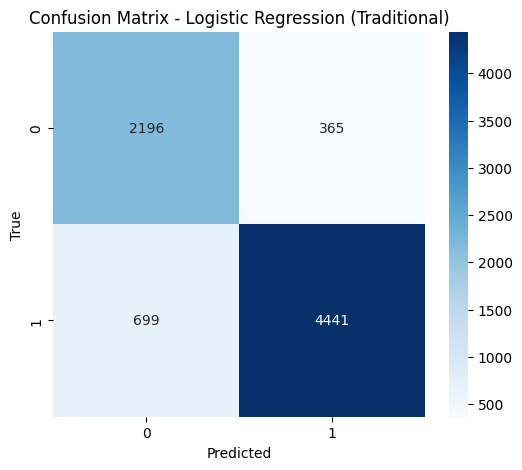

⏱ Training Time: 0.11 seconds
 Model and Vectorizer saved successfully.


In [ ]:
# --- Evaluate ---
y_pred_log_reg_trad = log_reg_model_trad.predict(X_val_tfidf_trad)

acc = accuracy_score(y_trad_val, y_pred_log_reg_trad)
prec = precision_score(y_trad_val, y_pred_log_reg_trad)
rec = recall_score(y_trad_val, y_pred_log_reg_trad)
f1 = f1_score(y_trad_val, y_pred_log_reg_trad)

print(f"\nLogistic Regression (Traditional Preprocessing)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_trad_val, y_pred_log_reg_trad))

# --- Confusion Matrix ---
cm = confusion_matrix(y_trad_val, y_pred_log_reg_trad)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (Traditional)")
plt.show()

print(f"⏱ Training Time: {end_time - start_time:.2f} seconds")

# --- Save Model & Vectorizer ---
with open(OUTPUT_DIR + 'baseline_logreg_trad_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model_trad, f)
with open(OUTPUT_DIR + 'tfidf_vectorizer_trad.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer_trad, f)

print(" Model and Vectorizer saved successfully.")

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-24088088.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.305800,0.298421,0.887417,0.908274,0.924708,0.916418
2,0.179700,0.319979,0.890793,0.912810,0.924708,0.918720


DistilBERT model & tokenizer saved at /content/drive/MyDrive/Disaster_Analyzer_Data/DistilBERT/saved_model



Evaluation Metrics (DistilBERT)
Accuracy : 0.8907934034540969
Precision: 0.9128096792778951
Recall   : 0.9247081712062257
F1 Score : 0.918720402048903

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      2561
           1       0.91      0.92      0.92      5140

    accuracy                           0.89      7701
   macro avg       0.88      0.87      0.88      7701
weighted avg       0.89      0.89      0.89      7701



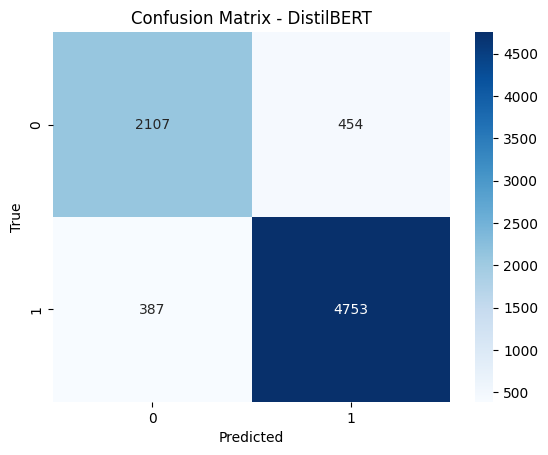

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Binary dataset using text_cleaned ---
bert_binary_data = final_train_pool[['text_cleaned', 'is_disaster']].dropna()
bert_binary_data['is_disaster'] = bert_binary_data['is_disaster'].astype(int)

# Train-test split
bert_X_train, bert_X_val, bert_y_train, bert_y_val = train_test_split(
    bert_binary_data['text_cleaned'],
    bert_binary_data['is_disaster'],
    test_size=0.2,
    random_state=42,
    stratify=bert_binary_data['is_disaster']
)

# Tokenizer
bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

bert_train_encodings = bert_tokenizer(list(bert_X_train), truncation=True, padding=True, max_length=128)
bert_val_encodings   = bert_tokenizer(list(bert_X_val), truncation=True, padding=True, max_length=128)

# Dataset class
class BertDisasterDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

bert_train_dataset = BertDisasterDataset(bert_train_encodings, list(bert_y_train))
bert_val_dataset   = BertDisasterDataset(bert_val_encodings, list(bert_y_val))

# Model
bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Training Arguments (newer transformers syntax)
bert_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Disaster_Analyzer_Data/DistilBERT/results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Disaster_Analyzer_Data/DistilBERT/logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
)

# Define compute_metrics function
def bert_compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Trainer
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_val_dataset,
    tokenizer=bert_tokenizer,
    compute_metrics=bert_compute_metrics,
)

# --- Train ---
bert_trainer.train()

# --- Save Model & Tokenizer ---
save_dir = "/content/drive/MyDrive/Disaster_Analyzer_Data/DistilBERT/saved_model"
os.makedirs(save_dir, exist_ok=True)
bert_model.save_pretrained(save_dir)
bert_tokenizer.save_pretrained(save_dir)

print(f"DistilBERT model & tokenizer saved at {save_dir}")

# --- Evaluate ---
bert_preds = bert_trainer.predict(bert_val_dataset)
bert_y_preds = bert_preds.predictions.argmax(-1)

print("\nEvaluation Metrics (DistilBERT)")
print("Accuracy :", accuracy_score(bert_y_val, bert_y_preds))
print("Precision:", precision_score(bert_y_val, bert_y_preds))
print("Recall   :", recall_score(bert_y_val, bert_y_preds))
print("F1 Score :", f1_score(bert_y_val, bert_y_preds))
print("\nClassification Report:\n", classification_report(bert_y_val, bert_y_preds))

# --- Confusion Matrix ---
bert_cm = confusion_matrix(bert_y_val, bert_y_preds)
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import numpy as np
import os
import pandas as pd


MODEL_NAME = 'distilbert-base-uncased'
MODELS_DIR = '/content/drive/MyDrive/Disaster_Analyzer_Data/Models/'

# --- 1. Determine Labels and Mapping (CRITICAL FOR MULTI-CLASS) ---
# We must map the string labels (like 'requests_or_urgent_needs') to unique integers (0, 1, 2, ...)
label_list = sorted(list(y_multi_train.unique()))
label_to_id = {label: i for i, label in enumerate(label_list)}
NUM_MULTI_LABELS = len(label_list)

# Map the string labels to integers for training
y_multi_train_ids = y_multi_train.map(label_to_id)
y_multi_val_ids = y_multi_val.map(label_to_id)

print(f"Total Unique Multi-Classes: {NUM_MULTI_LABELS}")
print(f"Sample Mapped Labels: {list(label_to_id.items())[:3]}")
print("---")

# --- 2. Tokenization and Dataset Creation ---
tokenizer_multi = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

train_encodings_multi = tokenizer_multi(list(X_multi_train), truncation=True, padding=True, max_length=128)
val_encodings_multi   = tokenizer_multi(list(X_multi_val), truncation=True, padding=True, max_length=128)

# Re-using the previously defined BertDisasterDataset class
class BertDisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset_multi = BertDisasterDataset(train_encodings_multi, list(y_multi_train_ids))
val_dataset_multi   = BertDisasterDataset(val_encodings_multi, list(y_multi_val_ids))

# Model initialization: num_labels is set to the count of your unique sub-categories
model_multi = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_MULTI_LABELS)

# --- 3. Metrics Function (Adjusted for Multi-Class) ---
def compute_metrics_multi(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    # CRITICAL CHANGE: Use 'weighted' average for multi-class F1/Precision/Recall
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# --- 4. Trainer and Training ---
training_args_multi = TrainingArguments(
    output_dir=MODELS_DIR + 'distilbert_multi_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs_multi',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"
)

trainer_multi = Trainer(
    model=model_multi,
    args=training_args_multi,
    train_dataset=train_dataset_multi,
    eval_dataset=val_dataset_multi,
    compute_metrics=compute_metrics_multi,
    tokenizer=tokenizer_multi,
)

print("\nStarting DistilBERT Multi-Class Model Training...")
trainer_multi.train()

# --- 5. Final Evaluation and Saving ---
multi_preds = trainer_multi.predict(val_dataset_multi)
multi_y_preds = multi_preds.predictions.argmax(-1)

print("\n DistilBERT Evaluation Results (Multi-Class Category)")
# Print the full classification report using the original string labels
print("\nClassification Report:\n", classification_report(y_multi_val_ids, multi_y_preds, target_names=label_list, zero_division=0))

# Create the new subfolder path
MULTI_MODEL_PATH = MODELS_DIR + "distilbert_multi_category_model/"
os.makedirs(MULTI_MODEL_PATH, exist_ok=True)

# Save the Multi-Class Model and Tokenizer to the new subfolder
model_multi.save_pretrained(MULTI_MODEL_PATH)
tokenizer_multi.save_pretrained(MULTI_MODEL_PATH)
print(f" DistilBERT Multi-Class Model saved to {MULTI_MODEL_PATH}")

Total Unique Multi-Classes: 15
Sample Mapped Labels: [('caution_and_advice', 0), ('direct-eyewitness', 1), ('displaced_people_and_evacuations', 2)]
---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2384719333.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_multi = Trainer(



Starting DistilBERT Multi-Class Model Training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.725300,0.694333,0.777112,0.762897,0.777112,0.763578
2,0.562100,0.658510,0.781968,0.769416,0.781968,0.773975
3,0.451900,0.670046,0.788605,0.777741,0.788605,0.781682



 DistilBERT Evaluation Results (Multi-Class Category)

Classification Report:
                                         precision    recall  f1-score   support

                    caution_and_advice       0.62      0.63      0.63       271
                     direct-eyewitness       0.68      0.64      0.66       103
      displaced_people_and_evacuations       0.89      0.95      0.92       365
                            don't know       0.90      0.92      0.91       930
                   indirect-eyewitness       0.00      0.00      0.00         6
     infrastructure_and_utility_damage       0.82      0.88      0.85       720
                injured_or_dead_people       0.92      0.95      0.93       489
                        non-eyewitness       0.75      0.70      0.72       107
                      not_humanitarian       0.42      0.24      0.31       237
            other_relevant_information       0.59      0.56      0.58       936
              requests_or_urgent_needs 

In [ ]:

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import numpy as np
import os
import pandas as pd

# --- Configuration ---
# Assuming X_multi_train/val and y_multi_train/val are loaded in memory
MODEL_NAME = 'distilbert-base-uncased'
MODELS_DIR = '/content/drive/MyDrive/Disaster_Analyzer_Data/Models/'

# Define the NEW, SPECIFIC save path for the finetuned model
FINETUNED_MODEL_NAME = "distilbert_multi_category_model_finetuned"
FINETUNED_MODEL_PATH = MODELS_DIR + FINETUNED_MODEL_NAME + "/"
os.makedirs(FINETUNED_MODEL_PATH, exist_ok=True) # Ensure the directory exists

# --- 1. Determine Labels and Mapping (CRITICAL FOR MULTI-CLASS) ---
label_list = sorted(list(y_multi_train.unique()))
label_to_id = {label: i for i, label in enumerate(label_list)}
NUM_MULTI_LABELS = len(label_list)

# Map the string labels to integers for training
y_multi_train_ids = y_multi_train.map(label_to_id)
y_multi_val_ids = y_multi_val.map(label_to_id)

print(f"Total Unique Multi-Classes: {NUM_MULTI_LABELS}")
print(f"Sample Mapped Labels: {list(label_to_id.items())[:3]}")
print("---")

# --- 2. Tokenization and Dataset Creation ---
tokenizer_multi = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

train_encodings_multi = tokenizer_multi(list(X_multi_train), truncation=True, padding=True, max_length=128)
val_encodings_multi   = tokenizer_multi(list(X_multi_val), truncation=True, padding=True, max_length=128)

# Re-using the previously defined BertDisasterDataset class
class BertDisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset_multi = BertDisasterDataset(train_encodings_multi, list(y_multi_train_ids))
val_dataset_multi   = BertDisasterDataset(val_encodings_multi, list(y_multi_val_ids))

# Model initialization: num_labels is set to the count of your unique sub-categories
model_multi_finetuned = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_MULTI_LABELS)

# --- 3. Metrics Function (Adjusted for Multi-Class) ---
def compute_metrics_multi(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    # Use 'weighted' average for multi-class F1/Precision/Recall
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# --- 4. Trainer and Training ---
# CRITICAL CHANGE: num_train_epochs is 5
training_args_multi = TrainingArguments(
    output_dir=MODELS_DIR + 'distilbert_multi_results_finetuned',
    num_train_epochs=5, # INCREASED EPOCHS FOR FINETUNING
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs_multi_finetuned',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"
)

trainer_multi_finetuned = Trainer(
    model=model_multi_finetuned,
    args=training_args_multi,
    train_dataset=train_dataset_multi,
    eval_dataset=val_dataset_multi,
    compute_metrics=compute_metrics_multi,
    tokenizer=tokenizer_multi,
)

print("\nStarting Finetuning of Multi-Class Model for 5 Epochs ")
trainer_multi_finetuned.train()

# --- 5. Final Evaluation and Saving ---
multi_preds_finetuned = trainer_multi_finetuned.predict(val_dataset_multi)
multi_y_preds_finetuned = multi_preds_finetuned.predictions.argmax(-1)

print("\n DistilBERT Evaluation Results (Multi-Class FINETUNED)")
# Print the full classification report using the original string labels
print("\nClassification Report:\n", classification_report(y_multi_val_ids, multi_y_preds_finetuned, target_names=label_list, zero_division=0))

# Save the Finetuned Model to the new path
model_multi_finetuned.save_pretrained(FINETUNED_MODEL_PATH)
tokenizer_multi.save_pretrained(FINETUNED_MODEL_PATH)
print(f" FINETUNED DistilBERT Multi-Class Model saved to {FINETUNED_MODEL_PATH}")

Total Unique Multi-Classes: 15
Sample Mapped Labels: [('caution_and_advice', 0), ('direct-eyewitness', 1), ('displaced_people_and_evacuations', 2)]
---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1575254006.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_multi_finetuned = Trainer(



Starting Finetuning of Multi-Class Model for 5 Epochs 


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.726500,0.685680,0.777436,0.762484,0.777436,0.764661
2,0.566200,0.665419,0.778407,0.769989,0.778407,0.772101
3,0.440800,0.678283,0.785529,0.775956,0.785529,0.779713
4,0.345000,0.732144,0.782778,0.777261,0.782778,0.779624
5,0.255900,0.779123,0.779055,0.771039,0.779055,0.774352



 DistilBERT Evaluation Results (Multi-Class FINETUNED)

Classification Report:
                                         precision    recall  f1-score   support

                    caution_and_advice       0.66      0.58      0.62       271
                     direct-eyewitness       0.69      0.66      0.67       103
      displaced_people_and_evacuations       0.89      0.93      0.91       365
                            don't know       0.90      0.92      0.91       930
                   indirect-eyewitness       0.00      0.00      0.00         6
     infrastructure_and_utility_damage       0.82      0.88      0.85       720
                injured_or_dead_people       0.89      0.96      0.93       489
                        non-eyewitness       0.72      0.75      0.73       107
                      not_humanitarian       0.37      0.31      0.34       237
            other_relevant_information       0.61      0.54      0.58       936
              requests_or_urgent_needs

In [1]:
!pip install huggingface_hub

In [26]:
from huggingface_hub import login

# This will open a browser prompt for you to paste your token
login()

In [ ]:
from huggingface_hub import HfApi
import os
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import pandas as pd
import re

# --- CRITICAL: Replace this placeholder with your actual WRITE token string ---
YOUR_ACTUAL_HF_TOKEN = "YOUR_ACTUAL_HF_TOKEN"

api = HfApi(token=YOUR_ACTUAL_HF_TOKEN)

# Define Local Paths (Model locations in your Drive)
LOCAL_PATH_BIN = '/content/drive/MyDrive/Disaster_Analyzer_Data/DistilBERT/saved_model/'
LOCAL_PATH_MULTI = '/content/drive/MyDrive/Disaster_Analyzer_Data/Models/distilbert_multi_category_model_finetuned/'

# Define New Hugging Face Repository IDs (Use your actual username)
HF_USER = "Vivek1564"
HF_REPO_BIN = f"{HF_USER}/disaster-tweet-binary-filter"
HF_REPO_MULTI = f"{HF_USER}/disaster-tweet-multi-category-finetuned"

# --- Upload Models ---
print("\n--- Starting Final Upload to Hugging Face Hub ---")

try:
    # 1. Upload Binary Model
    api.create_repo(repo_id=HF_REPO_BIN, exist_ok=True, private=False, repo_type="model", token=YOUR_ACTUAL_HF_TOKEN)
    api.upload_folder(folder_path=LOCAL_PATH_BIN, repo_id=HF_REPO_BIN, repo_type="model", token=YOUR_ACTUAL_HF_TOKEN)
    print(f" Binary Model uploaded to: https://huggingface.co/{HF_REPO_BIN}")

    # 2. Upload Multi-Class Model
    api.create_repo(repo_id=HF_REPO_MULTI, exist_ok=True, private=False, repo_type="model", token=YOUR_ACTUAL_HF_TOKEN)
    api.upload_folder(folder_path=LOCAL_PATH_MULTI, repo_id=HF_REPO_MULTI, repo_type="model", token=YOUR_ACTUAL_HF_TOKEN)
    print(f" Multi-Class Model uploaded to: https://huggingface.co/{HF_REPO_MULTI}")

except Exception as e:
    print(f" FATAL ERROR. UPLOAD FAILED. Error: {e}")
    print("Please verify the token string is correct and has WRITE permissions.")


--- Starting Final Upload to Hugging Face Hub ---


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d_model/model.safetensors:   3%|2         | 6.92MB /  268MB            

 Binary Model uploaded to: https://huggingface.co/Vivek1564/disaster-tweet-binary-filter


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...netuned/model.safetensors:   0%|          | 12.5kB /  268MB            

 Multi-Class Model uploaded to: https://huggingface.co/Vivek1564/disaster-tweet-multi-category-finetuned


In [30]:
# --- STEP 7B: FINAL PREDICTION SCRIPT (USING HUGGING FACE HUB IDs) ---

import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import os
import re

# Define paths and constants
DATA_ROOT = '/content/drive/MyDrive/Disaster_Analyzer_Data/'
FINAL_DASHBOARD_FILE = DATA_ROOT + 'dashboard_data_final.csv'

# --- HUGGING FACE HUB IDs (CRITICAL CHANGE) ---
HF_USER = "Vivek1564"
BIN_REPO_ID = f"{HF_USER}/disaster-tweet-binary-filter"
MULTI_REPO_ID = f"{HF_USER}/disaster-tweet-multi-category-finetuned"
# ---------------------------------------------


# Load Test Data (CSV)
df_test = pd.read_csv(DATA_ROOT + 'kaggle_test_final_unlabeled.csv')

# --- VERIFICATION STEP (Cleaning function definition must be here) ---
if 'text_cleaned' not in df_test.columns:
    def clean_text_global(text):
        text = str(text).lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#', '', text)
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text
    df_test['text_cleaned'] = df_test['text'].apply(clean_text_global)

# Load Models from Hugging Face Hub (This step is now stable)
try:
    tokenizer_bin = DistilBertTokenizerFast.from_pretrained(BIN_REPO_ID)
    model_bin = DistilBertForSequenceClassification.from_pretrained(BIN_REPO_ID)
    tokenizer_multi = DistilBertTokenizerFast.from_pretrained(MULTI_REPO_ID)
    model_multi = DistilBertForSequenceClassification.from_pretrained(MULTI_REPO_ID)
    print(f" Models loaded successfully from Hugging Face Hub.")

except Exception as e:
    print(f" FATAL ERROR: MODEL LOAD FAILED. Error: {e}")
    print("Check your internet connection and verify the repo IDs are spelled exactly right.")
    exit()


# Re-create Label Mapping (Crucial)
LABEL_LIST = sorted(['caution_and_advice', 'direct-eyewitness', 'displaced_people_and_evacuations',
                     "don't know", 'indirect-eyewitness', 'infrastructure_and_utility_damage',
                     'injured_or_dead_people', 'non-eyewitness', 'not_humanitarian',
                     'other_relevant_information', 'requests_or_urgent_needs',
                     'rescue_volunteering_or_donation_effort', 'sympathy_and_support',
                     'vulnerable direct-eyewitness', 'vulnerable-direct witness'])
ID_TO_LABEL = {i: label for i, label in enumerate(LABEL_LIST)}

# --- Prediction Logic ---
def predict_full_set(df):
    # 1. Binary Prediction
    test_encodings = tokenizer_bin(list(df['text_cleaned']), truncation=True, padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        logits = model_bin(**test_encodings).logits
    df['is_disaster_pred'] = logits.argmax(dim=1).cpu().numpy()

    # 2. Multi-Class Prediction (Only on confirmed disasters)
    df_disaster = df[df['is_disaster_pred'] == 1].copy()

    if df_disaster.empty:
        return df

    multi_encodings = tokenizer_multi(list(df_disaster['text_cleaned']), truncation=True, padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        logits_multi = model_multi(**multi_encodings).logits
    multi_pred_ids = logits_multi.argmax(dim=1).cpu().numpy()
    df_disaster['purpose_pred'] = [ID_TO_LABEL.get(id, 'CLASSIFICATION ERROR') for id in multi_pred_ids]

    # 3. Merge back and finalize
    df = pd.merge(df, df_disaster[['id', 'purpose_pred']], on='id', how='left')
    df['purpose_pred'].fillna('NOT APPLICABLE', inplace=True)

    return df

# --- EXECUTE AND SAVE ---
print("\n--- Starting Final Prediction Run ---")
final_dashboard_df = predict_full_set(df_test)
final_dashboard_df.to_csv(FINAL_DASHBOARD_FILE, index=False)
print(f"\n Final Dashboard Data saved to {FINAL_DASHBOARD_FILE}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

 Models loaded successfully from Hugging Face Hub.

--- Starting Final Prediction Run ---

 Final Dashboard Data saved to /content/drive/MyDrive/Disaster_Analyzer_Data/dashboard_data_final.csv


/tmp/ipython-input-3352591446.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['purpose_pred'].fillna('NOT APPLICABLE', inplace=True)


In [31]:
!huggingface-cli logout

⚠️  Warning: 'huggingface-cli logout' is deprecated. Use 'hf auth logout' instead.
Successfully logged out from all access tokens.
